In [1]:
import datetime
from dateutil import parser as date_parser
import git
from pathlib import Path
from datetime import date
from matplotlib import pyplot as plt
import pandas as pd
import scienceplots

plt.style.use("science")
plt.style.use("notebook")

In [2]:
# Get a list of repositories that I already cloned
base_path = Path("~/Documents/23/git_sync/hsf-training2/").expanduser()
base_path.mkdir(parents=True, exist_ok=True)
repo_paths = [p for p in base_path.iterdir() if p.is_dir() and (p / ".git").is_dir()]
print(f"You got {len(repo_paths) = } already checked out")

You got len(repo_paths) = 50 already checked out


In [3]:
! gh repo list hsf-training --limit 1000  --json name -q '.[].name' > allrepos.txt

In [4]:
import subprocess


available_repos = Path("allrepos.txt").read_text().splitlines()
cloned_repos = [p.name for p in repo_paths]
print("Outdated repos: ", set(cloned_repos) - set(available_repos))
missing_repos = set(available_repos) - set(cloned_repos)
print(f"Found {len(missing_repos)} missing repos, here's how you can clone them")
for mr in missing_repos:
    # subprocess.run(f"gh repo clone hsf-training/{mr}", shell=True, cwd=base_path)
    print(f"gh repo clone hsf-training/{mr}")

Outdated repos:  set()
Found 0 missing repos, here's how you can clone them


In [5]:
from collections import defaultdict


class CommitCounter:
    def __init__(self):
        self._ignored_commit_messages = set()
        self._ignored_authors = set()
        #: Unique commits only
        self.timestamps = []
        #: Commits per repo
        self.timestamps_by_repo = defaultdict(list)
        self.duplicates = 0
        self.new_author_timestamps = []

    def ignore_commits_from(self, repo_path: Path, ignore_authors=True):
        r = git.Repo(repo_path)
        ign = 0
        igna = 0
        for commit in r.iter_commits():
            if not commit.message in self._ignored_commit_messages:
                ign += 1
            self._ignored_commit_messages.add(commit.message)
            # Slightly problematic
            if ignore_authors:
                self._ignored_authors.add(commit.author.email)
                igna += 1
        print(f"Ignored {ign:,} additional commits, {igna:,} authors")

    def scan_repo(self, repo_path: Path):
        r = git.Repo(repo_path)
        for commit in r.iter_commits():
            cd = date.fromtimestamp(commit.committed_date)
            if commit.author.email not in self._ignored_authors:
                self.new_author_timestamps.append(cd)
                self._ignored_authors.add(commit.author.email)
            if commit.message in self._ignored_commit_messages:
                self.duplicates += 1
                continue
            self.timestamps_by_repo[repo_path.name].append(cd)
            self.timestamps.append(cd)
            self._ignored_commit_messages.add(commit.message)

In [6]:
# r = git.Repo(repo_paths[0])
# for commit in r.iter_commits():
#     break

In [7]:
def dates2series(dates):
    start = min(dates)
    end = max(dates)
    index = [start + i * datetime.timedelta(days=1) for i in range((end - start).days)]
    # terribly inefficient
    values = [len([d for d in dates if d < ind]) for ind in index]
    return index, values

In [8]:
# Clone these repositories from Software Carpentry
# todo: Instead put the instructions for cloning them here

# git_sync gh repo list swcarpentry --limit 900 --json name -q '.[].name' 
# GraphQL: Could not resolve to a Repository with the name 'swcarpentry/git-novice-branch-pr'. (repository)


# Checking what repos are cloned first

# base_path = Path("~/Documents/22/git_sync/").expanduser()
# base_path.mkdir(parents=True, exist_ok=True)
# repo_paths = [p for p in base_path.iterdir() if p.is_dir() and (p / ".git").is_dir()]
# print(f"You got {len(repo_paths) = } already checked out")


In [9]:
cc = CommitCounter()
cc.ignore_commits_from(Path("~/Documents/22/git_sync/styles/").expanduser())
cc.ignore_commits_from(
    Path("~/Documents/22/git_sync/python-novice-inflammation/").expanduser()
)
cc.ignore_commits_from(Path("~/Documents/22/git_sync/git-novice/").expanduser())
cc.ignore_commits_from(Path("~/Documents/22/git_sync/shell-novice/").expanduser())
# cc.ignore_commits_from(
#     Path("~/Documents/22/git_sync/git-novice-branch-pr/").expanduser()
# )
cc.ignore_commits_from(Path("~/Documents/22/git_sync/workshop-template/").expanduser())
for r in repo_paths:
    cc.scan_repo(r)

Ignored 892 additional commits, 905 authors
Ignored 1,381 additional commits, 1,404 authors
Ignored 1,406 additional commits, 1,530 authors
Ignored 1,816 additional commits, 2,014 authors
Ignored 1,110 additional commits, 2,110 authors


In [10]:
cc.timestamps

[datetime.date(2022, 9, 19),
 datetime.date(2022, 9, 6),
 datetime.date(2022, 9, 5),
 datetime.date(2022, 8, 11),
 datetime.date(2022, 7, 28),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 18),
 datetime.date(2022, 7, 18),
 datetime.date(2022, 7, 18),
 datetime.date(2020, 10, 8),
 datetime.date(2020, 10, 8),
 datetime.date(2020, 8, 8),
 datetime.date(2020, 8, 8),
 datetime.date(2020, 8, 8),
 datetime.date(2020, 8, 8),
 datetime.date(2020, 7, 23),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 3),
 

In [11]:
dates, cumm = dates2series(cc.timestamps)
dates_authors, cumm_authors = dates2series(cc.new_author_timestamps)

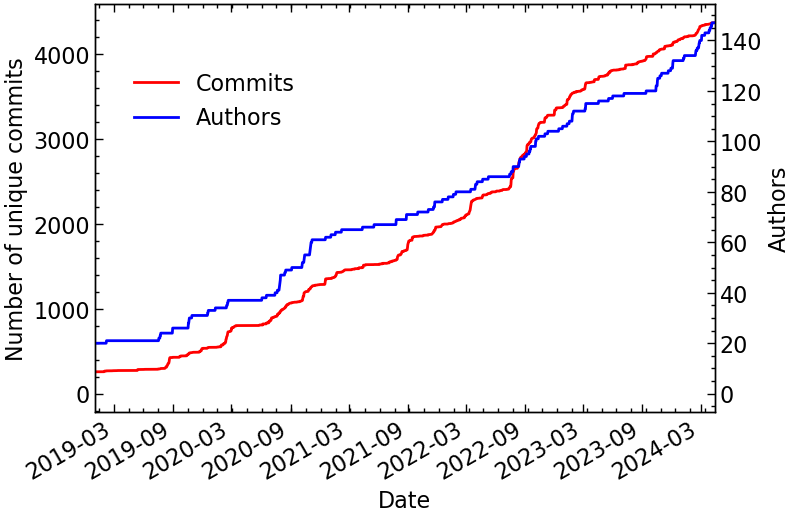

In [12]:
fig, ax = plt.subplots()
ax.plot(dates, cumm,label = 'Commits',color='red')
ax2 = ax.twinx()
ax2.plot(dates_authors, cumm_authors, label="Authors",color='blue')
ax2.set_ylabel("Authors")
ax.set_xlabel("Date")
ax.set_ylabel("Number of unique commits")
ax.set_xlim(date_parser.parse("01/01/2019"), datetime.datetime.now())
import matplotlib.dates as mdates

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
fig.legend(bbox_to_anchor = [0.4,0.8])
fig.autofmt_xdate()

In [13]:
data_dir = Path(".").resolve().parent / "data"
assert data_dir.is_dir()
pd.Series(cumm, index=dates).to_csv(data_dir / "total_commits.csv")
pd.Series(cumm_authors, index=dates_authors).to_csv(
    data_dir / "total_commit_authors.csv"
)

In [14]:
label_mapping = {
    "ml": "Machine learning",
    "cpluspluscourse": "C++",
    "cmake": "CMake",
    "cicd github": "CI/CD w/ github",
}

In [15]:
cc.timestamps_by_repo.keys()

dict_keys(['hsf-training-alpaka-webpage', 'organization', 'analysis-essentials', 'learner-certificates', 'hsf-training-minimal-github-actions-docker-build-push', 'hsf-training-ml-webpage', 'hsf-training-docker', 'hsf-training-matplotlib', 'repository-maintenance-test', 'hsf-training-singularity-webpage', 'chep23-proceeding-sustainability', 'cpluspluscourse', 'hsf-k12-python-for-stem-teachers', 'hsf_matplotlib_notebooks', 'csbs-paper', 'hsf-training-databases-basics', 'hsf-training-generators-webpage', 'hsf-training-cpp-webpage', 'hsf-training-minimal-github-actions-pytest', 'Python-for-STEM', 'hsf-training-cmake-webpage', 'hsf-training-ml-gpu-webpage', 'hsf-training-central-entry-point', 'carpentry-cookiecutter', 'training-center', 'hsf-training-scikit-hep-webpage', 'hsf-training-cicd-github', 'hsf-training-uproot-webpage', 'python-lesson', 'hsf-training-advanced-cpp-bits-webpage', 'hsf-training-advanced-git-webpage', 'hsf-training-intermediate-cpp', 'hsf-training-reana-webpage', 'hsf-

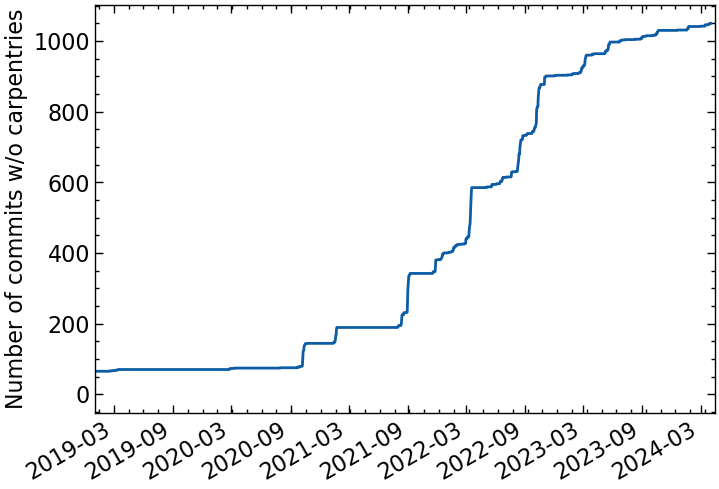

In [16]:
fig, ax = plt.subplots()
start_date = date_parser.parse("01/01/2019")
for r, vs in cc.timestamps_by_repo.items():
    # [d for d in vs if d > start_date.date()]
    label = ""
    alpha = 0.3
    ls = "-."
    dates, cumm = dates2series(vs)
    if len(vs) >= 90:
        l = r.replace("hsf-training-", "").replace("-webpage", "").replace("-", " ")
        label = label_mapping.get(l, l)
        alpha = 1
        label += rf" ($\Sigma$={max(cumm):,})"
        ls = "-"
    if not "C++" in label:
        continue
    ax.plot(dates, cumm, label=label, alpha=alpha, ls=ls)
ax.set_xlim(start_date, datetime.datetime.now())
# ax.legend()
ax.set_ylabel("Number of commits w/o carpentries")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
fig.autofmt_xdate()

In [17]:
# import numpy as np
#
# fig, ax = plt.subplots()
# start_date = date_parser.parse("01/01/2019")
# baseline = None
# for key, value in cc.timestamps_by_repo.items():
#     if baseline is None:
#         baseline = np.zeros_like(value)
#     dates, cumm = dates2series(vs)
#     label = None
#     ax.stairs(cumm+baseline, [*dates, datetime.datetime.now()], baseline=baseline, label=label, fill=True)
#     baseline = value
# ax.set_xlim(start_date, datetime.datetime.now())
# ax.legend()
# ax.set_ylabel("Number of commits w/o carpentries")
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# fig.autofmt_xdate()